## E13. 프로젝트 : 주식 예측에 도전해 보자

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 

**루브릭**

|평가문항|상세사항|
|:---|:---|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨|

### STEP 1 : 시계열 데이터 준비
---

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-27,56300.0,56900.0,55500.0,55900.0,53439.832031,23209541
1,2020-02-28,55000.0,55500.0,54200.0,54200.0,51814.648438,30054227
2,2020-03-02,54300.0,55500.0,53600.0,55000.0,52579.445313,30403412
3,2020-03-03,56700.0,56900.0,55100.0,55400.0,52961.839844,30330295
4,2020-03-04,54800.0,57600.0,54600.0,57400.0,54873.816406,24765728


In [217]:
print(len(df))

248


In [218]:
sam_df = df['Close']
sam_df.head()

0    55900.0
1    54200.0
2    55000.0
3    55400.0
4    57400.0
Name: Close, dtype: float64

In [219]:
print(type(sam_df))

<class 'pandas.core.series.Series'>


### STEP 2 : 각종 전처리 수행
---

* 결측치 처리
* 로그 변환

**데이터 안정성의 정성적 분석**

In [220]:
print(sam_df[sam_df.isna()])

Series([], Name: Close, dtype: float64)


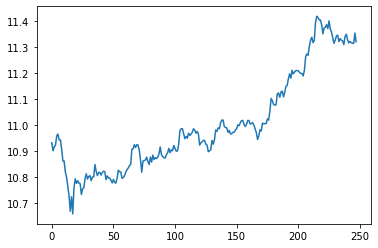

In [221]:
# 로그 변환
ts_log = np.log(sam_df)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석
---
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [222]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

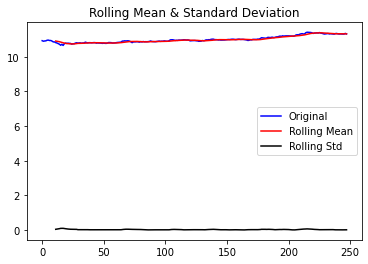

In [223]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [224]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.122974
p-value                          0.947102
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


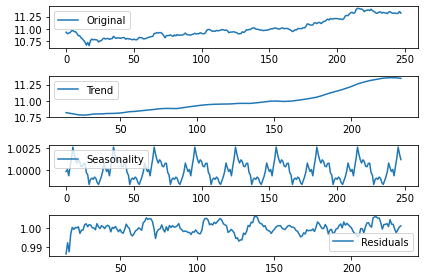

In [225]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [226]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.435169e+00
p-value                        1.659736e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성
---
* 학습, 테스트 데이터셋 분리

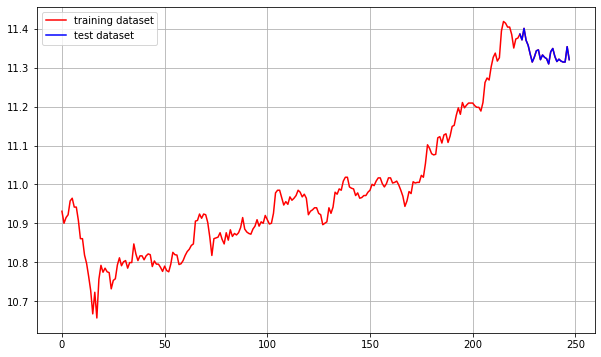

In [227]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기
---

* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

>ARIMA의 모수는 크게 3가지가 있다. AR모형의 Lag을 의미하는 p, MA모형의 Lag을 의미하는 q, 차분(Diffrence)횟수를 의미하는 d 가 그것이다. 보통은 p, d, q의 순서로 쓴다.
통상적으로 p + q < 2, p * q = 0 인 값들을 많이 사용한다.


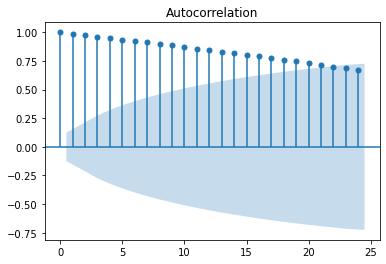

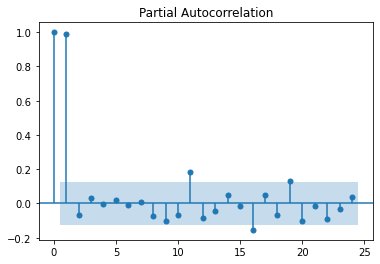

In [228]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF그래프가 일정하게 천천히 떨어지는 패턴을 보이므로, Non-Stationary data 로 보인다. 
* Differencing을 구해서 Stationary하도록 바꿔준다. == **integrated**

Results of Dickey-Fuller Test:
Test Statistic                -1.624548e+01
p-value                        3.690628e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


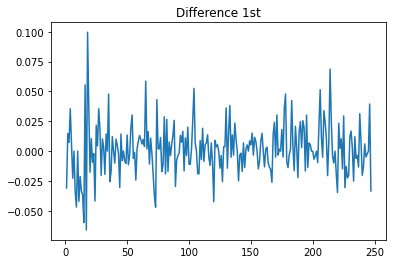

In [229]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.158102e+00
p-value                        3.017516e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


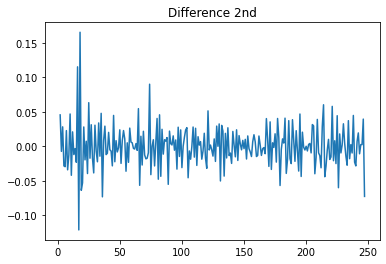

In [230]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

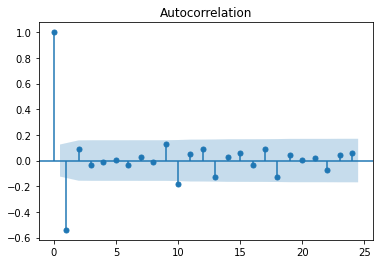

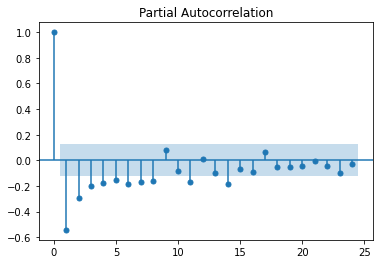

In [231]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* 2차 차분을 해준 후 데이터가 Stationary하게 바뀌었을 확인. ARIMA 모델에 사용하기 적합하게 되었다. 

### STEP 6 : ARIMA 모델 훈련과 테스트
---

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)


In [239]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(3, 2, 0))  #(P,D,Q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  221
Model:                 ARIMA(3, 2, 0)   Log Likelihood                 509.053
Method:                       css-mle   S.D. of innovations              0.024
Date:                Sat, 27 Feb 2021   AIC                          -1008.106
Time:                        22:34:51   BIC                           -991.115
Sample:                             2   HQIC                         -1001.245
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.085e-05      0.001      0.031      0.975      -0.001       0.001
ar.L1.D2.Close    -0.7753      0.067    -11.640      0.000      -0.906      -0.645
ar.L2.D2.Close    -0.4412      0.080

/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Figure(432x288)


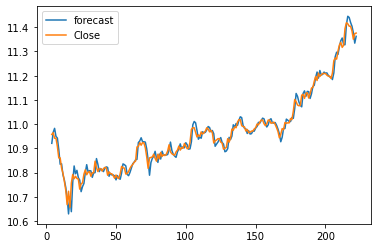

In [240]:
# 모델에 잘 fit되었는지 그래프로 확인 . 잘되었음

print(fitted_m.plot_predict())

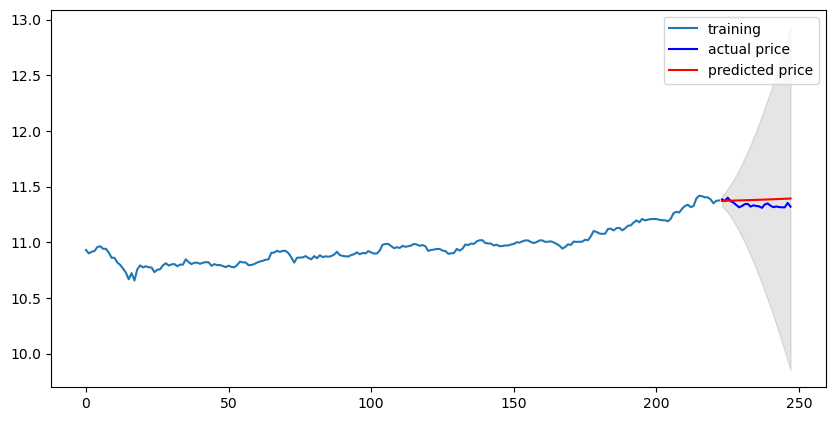

In [241]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [242]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  20117671.975458346
MAE:  4069.7701918694556
RMSE:  4485.272787184559
MAPE: 4.90%


### STEP 7 : 다른 주식 종목 예측해 보기 - TSLA
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### STEP 1 : TSLA 데이터 준비

In [134]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
data= pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(data))
data.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-27,146.000000,147.953995,133.800003,135.800003,135.800003,121386000
2020-02-28,125.940002,138.104004,122.304001,133.598007,133.598007,122821000
2020-03-02,142.251999,148.738007,137.334000,148.723999,148.723999,100975000
2020-03-03,161.000000,161.395996,143.222000,149.102005,149.102005,128920000
2020-03-04,152.792007,153.304001,144.945999,149.899994,149.899994,75245000


### STEP 2 : 전처리 수행

In [135]:
tsla_df = data['Close']
tsla_df.head()

Date
2020-02-27    135.800003
2020-02-28    133.598007
2020-03-02    148.723999
2020-03-03    149.102005
2020-03-04    149.899994
Name: Close, dtype: float64

In [136]:
# 결측치 제거
print(tsla_df[tsla_df.isna()])                                                        

Series([], Name: Close, dtype: float64)


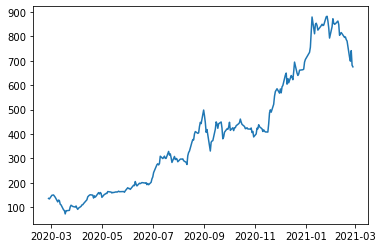

In [137]:
plt.plot(tsla_df)

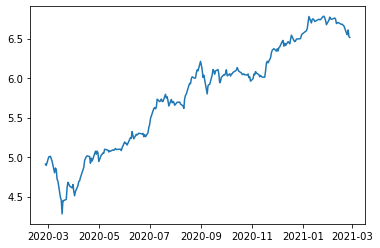

In [138]:
# 로그 변환
ts_tsla_log = np.log(tsla_df)
plt.plot(ts_tsla_log)

In [139]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

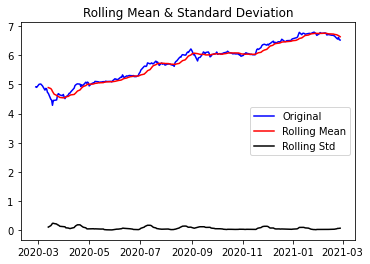

In [140]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_tsla_log, window=12)

In [141]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_tsla_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.760009
p-value                          0.830588
#Lags Used                       6.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


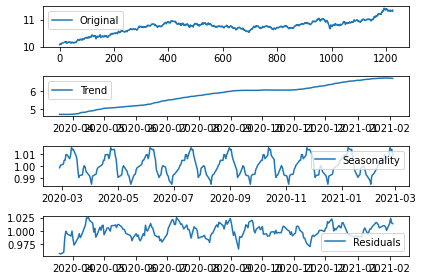

In [142]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_tsla_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [143]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.520535
p-value                          0.000002
#Lags Used                       3.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


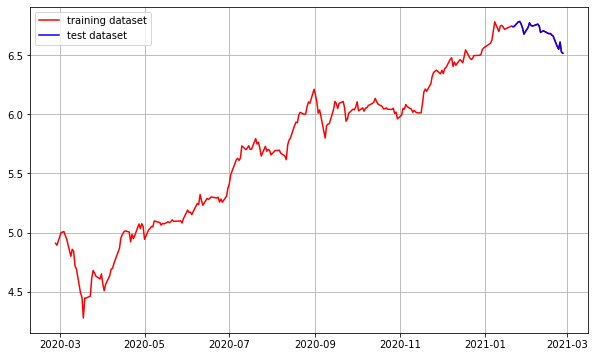

In [144]:
train_data, test_data = ts_tsla_log[:int(len(ts_tsla_log)*0.9)], ts_tsla_log[int(len(ts_tsla_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_tsla_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

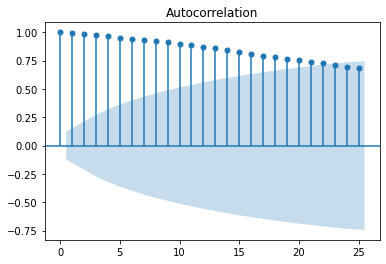

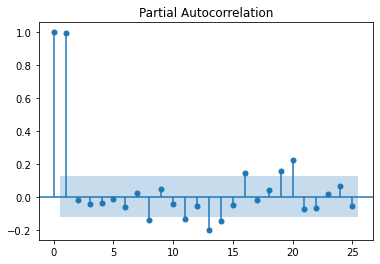

In [145]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_tsla_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_tsla_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.086686e+00
p-value                        4.519401e-10
#Lags Used                     5.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


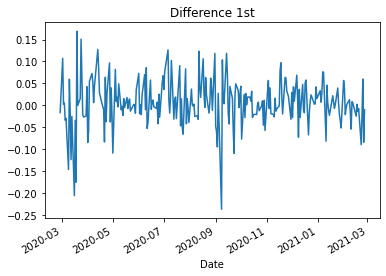

In [146]:
# 1차 차분 구하기
diff_1 = ts_tsla_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.800901e+00
p-value                        7.498226e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


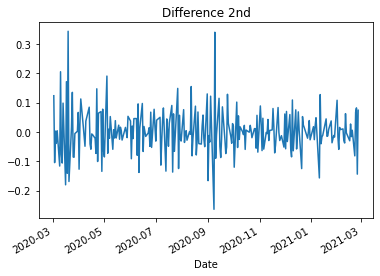

In [155]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [212]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(6, 2, 0))  #(P,D,Q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(6, 2, 0)   Log Likelihood                 321.680
Method:                       css-mle   S.D. of innovations              0.058
Date:                Sat, 27 Feb 2021   AIC                           -627.360
Time:                        22:31:24   BIC                           -600.031
Sample:                             2   HQIC                          -616.330
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.908e-05      0.001     -0.035      0.972      -0.002       0.002
ar.L1.D2.Close    -0.8627      0.065    -13.196      0.000      -0.991      -0.735
ar.L2.D2.Close    -0.5808      0.086

Figure(432x288)


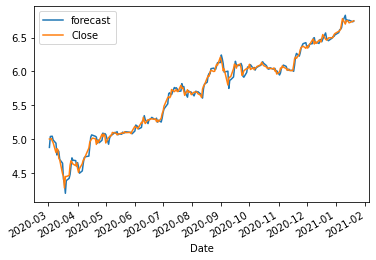

In [213]:
# 모델에 잘 fit되었는지 그래프로 확인 . 잘되었음

print(fitted_m.plot_predict())

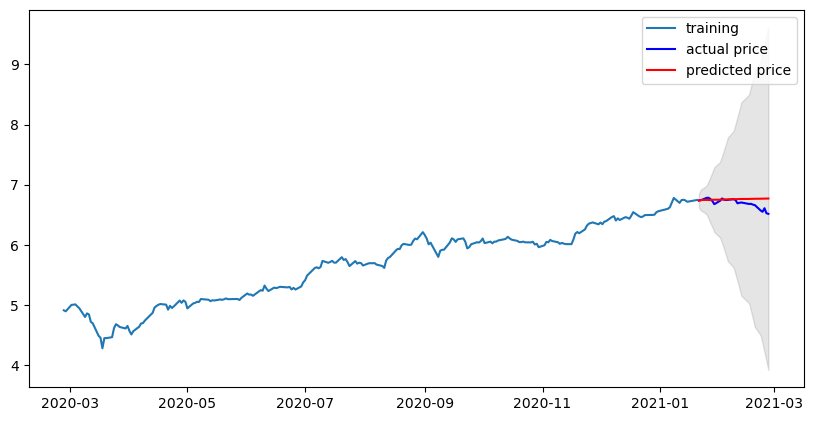

In [214]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [215]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7031.683538707424
MAE:  58.9714634168746
RMSE:  83.85513424178286
MAPE: 7.91%


### STEP 7 : 다른 주식 종목 예측해 보기 - GOOG
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

In [100]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
df= pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-29,700.320007,710.890015,697.679993,697.770020,697.770020,2481100
2016-03-01,703.619995,718.809998,699.770020,718.809998,718.809998,2151400
2016-03-02,719.000000,720.000000,712.000000,718.849976,718.849976,1629000
2016-03-03,718.679993,719.450012,706.020020,712.419983,712.419983,1958000
2016-03-04,714.989990,716.489990,706.020020,710.890015,710.890015,1972100


In [101]:
goog_df = df['Close']
goog_df.head()

Date
2016-02-29    697.770020
2016-03-01    718.809998
2016-03-02    718.849976
2016-03-03    712.419983
2016-03-04    710.890015
Name: Close, dtype: float64

In [102]:
# 결측치 제거

print(goog_df[goog_df.isna()])  

Series([], Name: Close, dtype: float64)


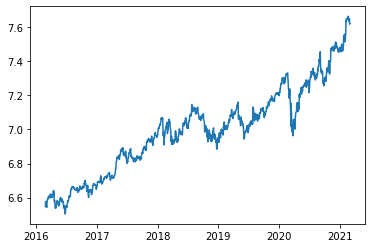

In [103]:
# 로그 변환
goog_df_log = np.log(goog_df)
plt.plot(goog_df_log)

In [104]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

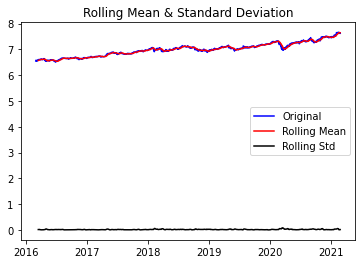

In [105]:
# 정성적 그래프 분석
plot_rolling_statistics(goog_df_log, window=12)

In [106]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(goog_df_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.215936
p-value                           0.936595
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


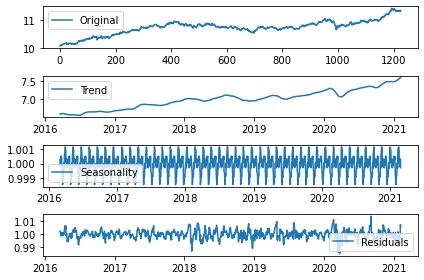

In [107]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(goog_df_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [108]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.043645e+01
p-value                        1.561917e-18
#Lags Used                     1.900000e+01
Number of Observations Used    1.209000e+03
Critical Value (1%)           -3.435770e+00
Critical Value (5%)           -2.863934e+00
Critical Value (10%)          -2.568044e+00
dtype: float64


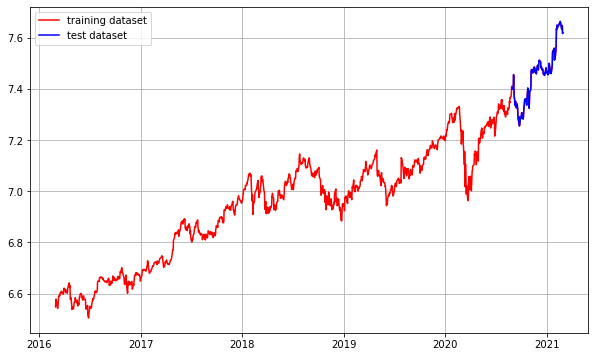

In [109]:
train_data, test_data = goog_df_log[:int(len(goog_df_log)*0.9)], goog_df_log[int(len(goog_df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(goog_df_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

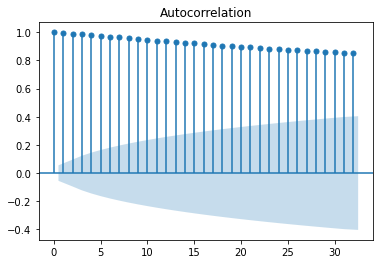

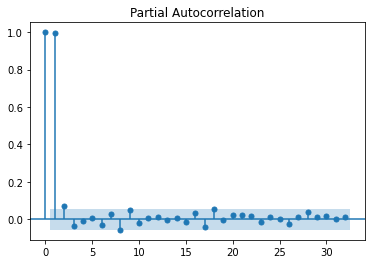

In [110]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(goog_df_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(goog_df_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.161125e+01
p-value                        2.510050e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


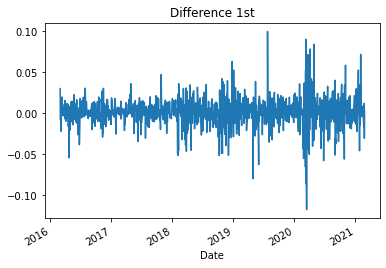

In [111]:
# 1차 차분 구하기
diff_1 = goog_df_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [112]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(0, 1, 2))  #(P,D,Q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1132
Model:                 ARIMA(0, 1, 2)   Log Likelihood                3062.006
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sat, 27 Feb 2021   AIC                          -6116.012
Time:                        22:12:42   BIC                          -6095.885
Sample:                             1   HQIC                         -6108.408
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      1.792      0.073   -7.08e-05       0.002
ma.L1.D.Close    -0.1478      0.030     -4.940      0.000      -0.206      -0.089
ma.L2.D.Close     0.0243      0.031     

/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date

Figure(432x288)


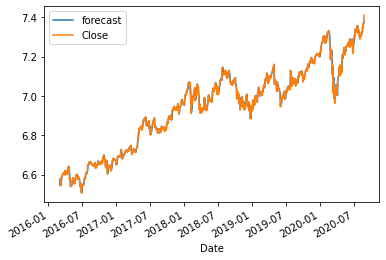

In [113]:
print(fitted_m.plot_predict())

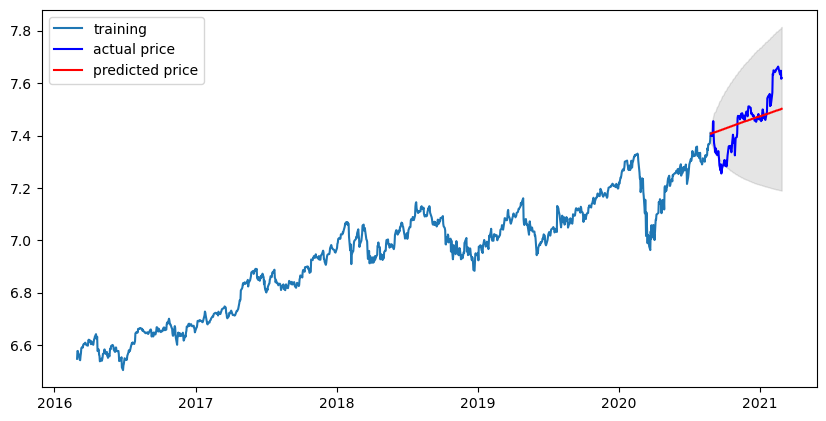

In [114]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  21753.515595591907
MAE:  113.53391997602965
RMSE:  147.490730541251
MAPE: 6.56%


### STEP 7 : 다른 주식 종목 예측해 보기 - FB
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

In [116]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/FB.csv'
df= pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-27,191.820007,195.880005,189.500000,189.750000,189.750000,21682600
2020-02-28,182.699997,192.740005,181.820007,192.470001,192.470001,32568900
2020-03-02,194.029999,196.570007,188.850006,196.440002,196.440002,24949000
2020-03-03,196.220001,197.240005,183.970001,185.889999,185.889999,27984100
2020-03-04,189.169998,191.830002,186.389999,191.759995,191.759995,23062500


In [117]:
FB_df = df['Close']
FB_df.head()

Date
2020-02-27    189.750000
2020-02-28    192.470001
2020-03-02    196.440002
2020-03-03    185.889999
2020-03-04    191.759995
Name: Close, dtype: float64

In [118]:
# 결측치 제거

print(FB_df[FB_df.isna()])  

Series([], Name: Close, dtype: float64)


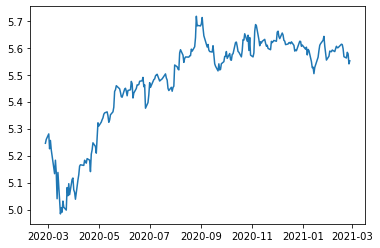

In [120]:
# 로그 변환
FB_df_log = np.log(FB_df)
plt.plot(FB_df_log)

In [121]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

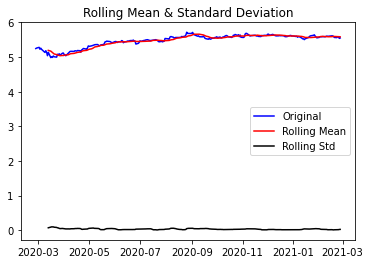

In [122]:
# 정성적 그래프 분석
plot_rolling_statistics(FB_df_log, window=12)

In [123]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(FB_df_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.613572
p-value                          0.476101
#Lags Used                       8.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


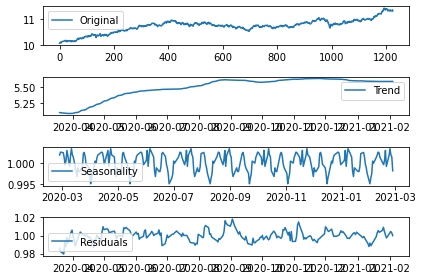

In [124]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(FB_df_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [125]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.091906e+00
p-value                        1.031651e-07
#Lags Used                     5.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


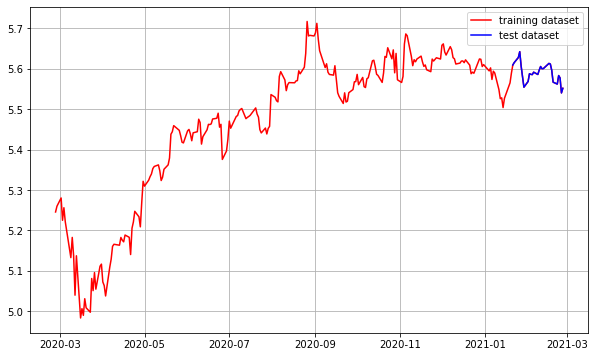

In [126]:
train_data, test_data = FB_df_log[:int(len(FB_df_log)*0.9)], FB_df_log[int(len(FB_df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(FB_df_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

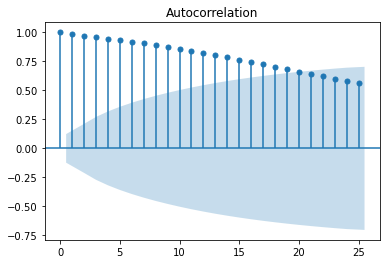

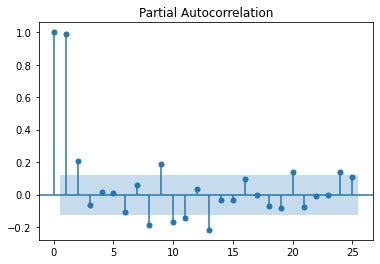

In [127]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(FB_df_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(FB_df_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.216994e+00
p-value                        2.160186e-10
#Lags Used                     5.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


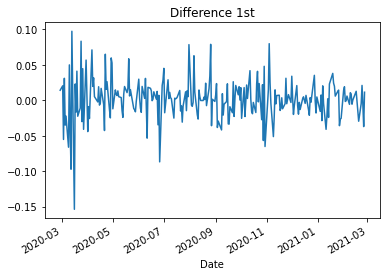

In [128]:
# 1차 차분 구하기
diff_1 = FB_df_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.336856e+00
p-value                        1.090823e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


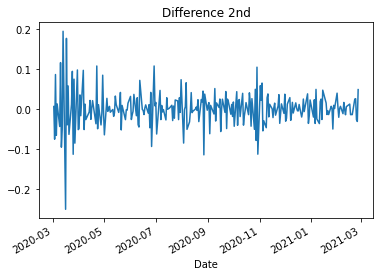

In [129]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [130]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(0, 2, 1))  #(P,D,Q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 466.228
Method:                       css-mle   S.D. of innovations              0.030
Date:                Sat, 27 Feb 2021   AIC                           -926.455
Time:                        22:21:12   BIC                           -916.207
Sample:                             2   HQIC                          -922.319
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.899e-06   3.72e-05     -0.239      0.811   -8.19e-05    6.41e-05
ma.L1.D2.Close    -0.9910      0.020    -49.853      0.000      -1.030      -0.952
                                    

/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date

Figure(432x288)


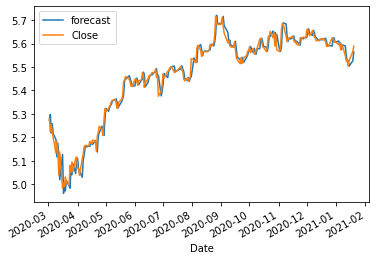

In [131]:
print(fitted_m.plot_predict())

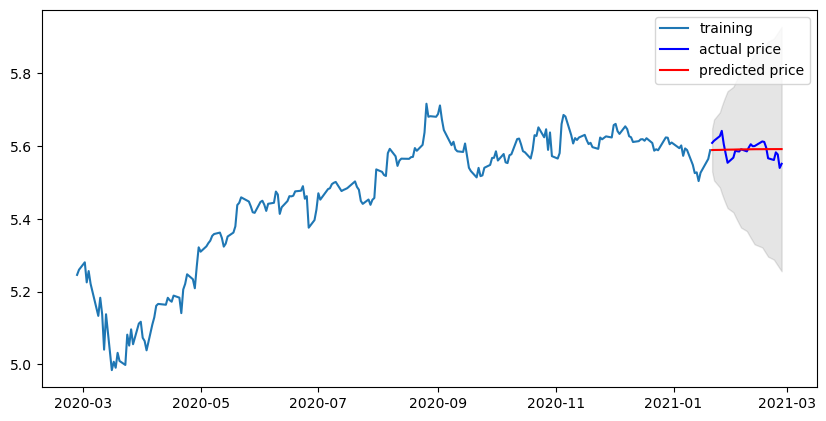

In [132]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [133]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40.908057944000916
MAE:  5.071335476812653
RMSE:  6.395940739562939
MAPE: 1.90%


## 총평

* ARIMA 모델의 P,D,Q 계수를 조정하여, 데이터에 맞는 학습을 진행하였다. 
* 유튜브 강의로 ARIMA 관련 학습을 하면서 P,Q 의 계수를 0~20까지 조정할 수 있다는 것과 차분(D)의 경우 보통 최대 2차분까지 하여 반영을 하는것이 좋으며, 3차분을 해야할 경우는 ARIMA 모델에 적합한 데이터가 아님을 알았다. 
* 데이터의 수집에 있어서도 6개월~5년까지의 데이터를 비교해보아서 되도록 결측치가 없고 안정성 변환이 용이한 구간의 데이터를 사용하는 것이 MAPE를 10% 미만으로 정확도를 높이기에 좋았다. 
* 시행착오가 많았지만, 처음에는 20%이상의 오차률을 보이던 데이터들이  **삼성 4.9% / 테슬라 7.9% / 구글 6.5% / 페이스북 1.9%** 로 줄어드는 과정을 보는것이 놀라웠다. 